# Getting Started with Lakes CCI Data

🔗 [ESA Climate Data Toolbox Website](https://climate.esa.int/en/data/toolbox/)

📘 A full list of dataset IDs can be retrieved from the store or found in the [ESA CCI Climate Toolbox documentation](https://esa-climate-toolbox.readthedocs.io/en/latest/quick_start.html#accessing-data).

In [6]:
from xcube.core.store import new_data_store
from esa_climate_toolbox.core import get_op
from esa_climate_toolbox.core import list_ecv_datasets
from esa_climate_toolbox.core import get_store
from esa_climate_toolbox.core import list_datasets
from esa_climate_toolbox.ops import plot
from shapely import Polygon
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Suppressing warnings to keep notebook output clean
%matplotlib inline

## Isolate to correct data product

In [8]:
cci_store = new_data_store("esa-cci")
# # List all available data sets of an ECV
# list_ecv_datasets("Lakes")

In [9]:
data_id = 'esacci.LAKES.day.L3S.LK_PRODUCTS.multi-sensor.multi-platform.MERGED.v2-1-0.r1'

## Metadata check before loading the data

In [10]:
lake_meta = gpd.read_file('shapefile/lakescci_v2.1.0_data-availability.shp')

In [11]:
metadata = cci_store.describe_data(data_id)

In [12]:
all_var_names = list(metadata.data_vars.keys())
full_dims = metadata.dims
time_freq = metadata.time_period
time_range = metadata.time_range

print('Temporal frequency:',time_freq, '\nTemporal range:',time_range)

Temporal frequency: 1D 
Temporal range: ('1992-09-26', '2022-12-31')


## Check allowed inputs before querying

In [13]:
param_schema = cci_store.get_open_data_params_schema(data_id=data_id, opener_id='dataset:zarr:cciodp')

In [14]:
print('Allowed variable names')
param_schema.properties['variable_names'].items

Allowed variable names


In [15]:
print('Spatial range (presumably latlon)')
param_schema.properties['bbox']

Spatial range (presumably latlon)


In [16]:
print('Time range')
param_schema.properties['time_range']

Time range


In [17]:
print('Processing steps')
param_schema.properties['normalize_data']

Processing steps


## Load data with parameters
Before opening the dataset, we define a few key parameters:

- **Time range**: the date(s) we want to load
- **Variables**: which data variable(s) to retrieve
- *(Optional)* **Bounding box**: spatial region of interest — as polygonLike

In [30]:
x1 = -23.40  # degree
y1 = -40.40  # degree
x2 = 57.40  # degree
y2 = 40.40  # degree

bbox = (x1, y1, x2, y2)

In [35]:
bbox = (-95.7,29.63,-92.9,33.32) # minx, miny, maxx, maxy
bbox_poly = spatial_functions.polygon_from_bbox(*bbox)

In [36]:
type(bbox_poly)

shapely.geometry.polygon.Polygon

In [37]:
variables = ['lake_surface_water_temperature']  # Variable to retrieve
start_date = '2022-06-19'    # Start and end date (same for a single timestep)
end_date = '2022-06-21'

### Step 7: Open the Dataset

Now we open the dataset using the selected parameters.  
The ESA Climate Toolbox will download only the necessary data (e.g., variable and time range).
You can always adjust the time range or variables to explore different slices of the dataset.

In [38]:
lakes_ds = cci_store.open_data(
    data_id=data_id,
    variable_names=variables,
    time_range=[start_date, end_date],
    bbox = bbox
)

### Step 8: Display Dataset Structure

We print a summary of the opened dataset to inspect its structure, dimensions, variables, and metadata.  
This helps verify that the data was loaded correctly and shows what is available for analysis and visualization.
This step is useful to understand what the dataset contains before working with it further.

In [41]:
print("\nOpened Dataset:\n", lakes_ds)


Opened Dataset:
 <xarray.Dataset> Size: 4MB
Dimensions:                         (time: 3, lat: 442, lon: 336, nv: 2, bnds: 2)
Coordinates:
  * lat                             (lat) float64 4kB 29.64 29.65 ... 33.3 33.31
    lat_bounds                      (lat, nv) float32 4kB dask.array<chunksize=(442, 2), meta=np.ndarray>
  * lon                             (lon) float64 3kB -95.7 -95.69 ... -92.9
    lon_bounds                      (lon, nv) float32 3kB dask.array<chunksize=(336, 2), meta=np.ndarray>
  * time                            (time) datetime64[ns] 24B 2022-06-19T12:0...
    time_bnds                       (time, bnds) datetime64[ns] 48B dask.array<chunksize=(3, 2), meta=np.ndarray>
Dimensions without coordinates: nv, bnds
Data variables:
    crs                             float64 8B ...
    lake_surface_water_temperature  (time, lat, lon) float64 4MB dask.array<chunksize=(1, 442, 336), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:           

## Map one variable

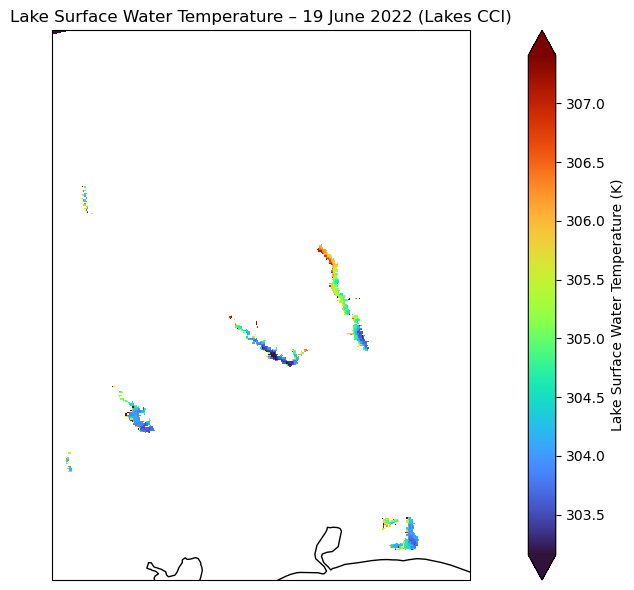

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select first (and only) time step and remove singleton dimension
lswt = lakes_ds["lake_surface_water_temperature"].isel(time=0).squeeze()
time_str = lakes_ds['time'].isel(time=0).dt.strftime('%d %B %Y').item()

# # For clarity and performance, you may want to subset the region (e.g., African lakes):
# lswt = lswt.sel(lat=slice(-15, 5), lon=slice(25, 45))

# Create figure and axis
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
mesh = lswt.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="turbo",  # or "inferno", "viridis", or "plasma"
    robust=True,
    cbar_kwargs={"label": "Lake Surface Water Temperature (K)"}
)

ax.coastlines()
ax.set_title("Lake Surface Water Temperature – " + time_str + " (Lakes CCI)")

# Add ticks
# ax.set_xticks(range(25, 45, 5), crs=ccrs.PlateCarree())  # longitude ticks
# ax.set_yticks(range(-15, 6, 5), crs=ccrs.PlateCarree())  # latitude ticks
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## Scratchwork 

In [1]:
variables = ['lake_surface_water_temperature',
                          'lswt_quality_level',
                          'lake_ice_cover_class'] # (list) Variables to extract
startdate = '2020-08-26' # (string) Startdate of the timeseries in the form (YYYY-MM-DD)
enddate = '2020-09-01'  # (string) Enddate of the timeseries in the form (YYYY-MM-DD)
compress = True          # (boolean) Apply z-lib compression
complevel = 4            # (int) Compression level to use
verbose = True      # (boolean) Print additional status updates
use_esacci = True
temp = False
merge_with_lakes = []

In [2]:
lakeid = 6
lakename = 'michigan'

In [ ]:
from xcube.core.store import new_data_store
from codebase import ROOT
from codebase.lakecci_functions import find_lakeid, find_lakename, valid_variables, get_shortname
from time import time
import geopandas as gpd
from codebase import constants as c

data_id = c.CCI_DATA_NAME
# Input checks
if not (bool(lakeid) or bool(lakename)):
    raise ValueError('At least one of the params lakeid and lakename '
                        'should be passed!')
elif not lakename:
    lakename = find_lakename(lakeid)
else:
    lakeid = find_lakeid(lakename)

if not valid_variables(variables):
    raise ValueError('The passed variable-list is invalid!')

    
time_start = time()

if verbose:
    print(f'Extracting {variables} for Lake {lakename} (ID{lakeid}) from '
            f'{startdate} to {enddate} from ESA CCI DataStore...')


# Define output path
fn_varnames = get_shortname(variables)
fn_output = f'ID{lakeid}-{lakename.lower()}-{fn_varnames}-{startdate.replace("-", "")}' \
    f'_{enddate.replace("-", "")}-v{c.VERSION}.extracted.nc'

if temp:
    path_output = ROOT.joinpath(c.PATH_EXTRACTED).joinpath('temp').joinpath(fn_output)
else:
    path_output = ROOT.joinpath(c.PATH_EXTRACTED).joinpath(fn_output)

path_output.parent.mkdir(parents=True, exist_ok=True)

# Create bbox from lakename or lakeID
## Load lake metadata with shp files
path_shp = ROOT.joinpath(c.PATH_AUXILIARY).joinpath(c.FN_SHP)
meta_full_shp = gpd.read_file(path_shp)
## Isolate lake(s) to extract
lakes_to_extract = [lakeid , *merge_with_lakes]
meta_shp = meta_full_shp.loc[meta_full_shp['id'].isin(lakes_to_extract)]
## Grab rectangular bbox from around lakes
bbox = meta_shp.union_all().bounds

# Run extraction from ESA CCI datastore
cci_store = new_data_store("esa-cci")
lakes_ds = cci_store.open_data(
        data_id=data_id,
        variable_names=variables,
        time_range=[startdate, enddate],
        bbox = bbox
)

# Save xr output as .nc
lakes_ds.to_netcdf(path_output)

Extracting ['lake_surface_water_temperature', 'lswt_quality_level', 'lake_ice_cover_class', 'crs'] for Lake michigan (ID6) from 2020-08-26 to 2020-09-01 from ESA CCI DataStore...


c:\Users\schelian\AppData\Local\anaconda3\envs\esaclimate\Lib\site-packages\xarray\core\duck_array_ops.py:250: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [36]:
lakes_ds

<xarray.Dataset> Size: 2GB
Dimensions:                         (time: 707, lat: 539, lon: 399, nv: 2,
                                     bnds: 2)
Coordinates:
  * lat                             (lat) float64 4kB 41.61 41.62 ... 46.09 46.1
    lat_bounds                      (lat, nv) float32 4kB dask.array<chunksize=(539, 2), meta=np.ndarray>
  * lon                             (lon) float64 3kB -88.05 -88.04 ... -84.73
    lon_bounds                      (lon, nv) float32 3kB dask.array<chunksize=(399, 2), meta=np.ndarray>
  * time                            (time) datetime64[ns] 6kB 2018-09-26T12:0...
    time_bnds                       (time, bnds) datetime64[ns] 11kB dask.array<chunksize=(707, 2), meta=np.ndarray>
Dimensions without coordinates: nv, bnds
Data variables:
    crs                             float64 8B ...
    lake_ice_cover_class            (time, lat, lon) float32 608MB dask.array<chunksize=(1, 539, 399), meta=np.ndarray>
    lake_surface_water_temperature  (time, lat, lon) float64 1GB dask.array<chunksize=(1, 539, 399), meta=np.ndarray>
    lswt_quality_level              (time, lat, lon) float32 608MB dask.array<chunksize=(1, 539, 399), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.LAKES.day.L3S.LK_PRODUCTS.multi-sensor.mu...
    date_created:            2025-10-16T13:22:58.241140
    processing_level:        L3S
    time_coverage_start:     2018-09-26T00:00:00
    time_coverage_end:       2020-09-02T00:00:00
    time_coverage_duration:  P707DT0H0M0S
    history:                 ['program', 'cube_params']

In [10]:
import xarray as xr
from codebase import ROOT
michigan = xr.open_dataset(ROOT/'data'/'extracted'/'ID6-michigan-LSWT_LSWTflag_LIC-20200826_20200901-v2.1.0.extracted.nc')

In [11]:
michigan

<xarray.Dataset> Size: 24MB
Dimensions:                         (time: 7, lat: 539, lon: 399, nv: 2, bnds: 2)
Coordinates:
  * lat                             (lat) float64 4kB 41.61 41.62 ... 46.09 46.1
    lat_bounds                      (lat, nv) float32 4kB ...
  * lon                             (lon) float64 3kB -88.05 -88.04 ... -84.73
    lon_bounds                      (lon, nv) float32 3kB ...
  * time                            (time) datetime64[ns] 56B 2020-08-26T12:0...
    time_bnds                       (time, bnds) datetime64[ns] 112B ...
Dimensions without coordinates: nv, bnds
Data variables:
    crs                             float64 8B ...
    lake_ice_cover_class            (time, lat, lon) float32 6MB ...
    lake_surface_water_temperature  (time, lat, lon) float64 12MB ...
    lswt_quality_level              (time, lat, lon) float32 6MB ...
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.LAKES.day.L3S.LK_PRODUCTS.multi-sensor.mu...
    date_created:            2025-10-16T16:14:00.914076
    processing_level:        L3S
    time_coverage_start:     2020-08-26T00:00:00
    time_coverage_end:       2020-09-02T00:00:00
    time_coverage_duration:  P7DT0H0M0S
    history:                 ['program', 'cube_params']

In [15]:
lswt = michigan['lake_surface_water_temperature']

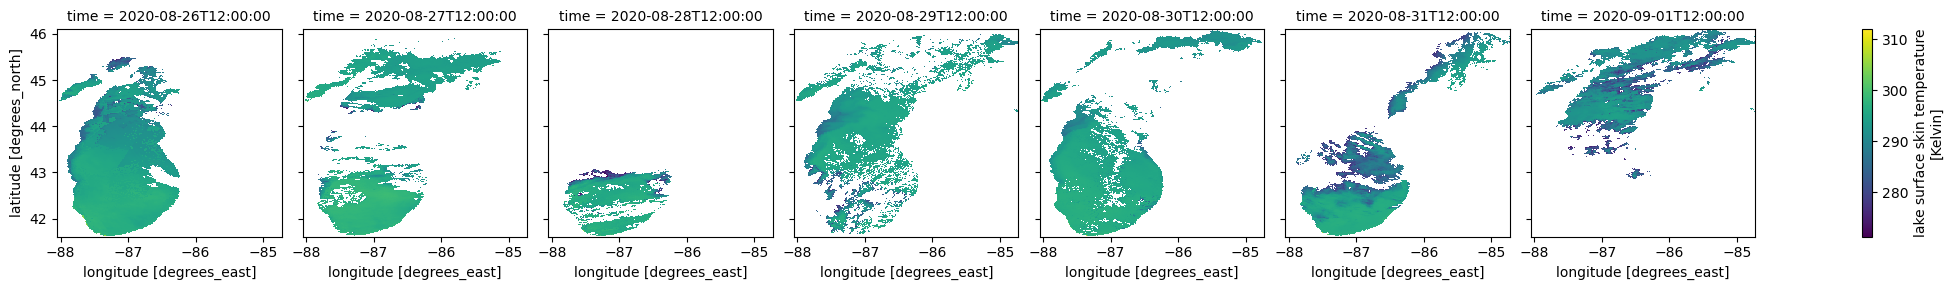

In [16]:
lswt.plot(x='lon',y='lat',col='time')